##### Initialization: definition of robots and coordinates

In [10]:
import numpy as np
from UAV import *
import random


#GLOBAL PARAMETERS
N_ROBOTS  = 5
DIMENSION = 2


platoon = []

# initialization of n robots
for i in range(N_ROBOTS):
    if i==0:
        i_robot = Robot("op_" + str(i),0,0,0)
    else:
        i_robot = Robot("op_" + str(i),round(random.uniform(0, 10.0),3),round(random.uniform(0, 10.0),3),0)
    platoon.append(i_robot)

coordinates = [[],[],[]]

for rob in platoon:
    coordinates = np.append(coordinates,rob.get_coords(),axis=1)

#TRUE COORDINATES [REALITY: THEY ARE UNKNOWN]
S = coordinates[0:2,:]

print(S)

[[0.    7.925 4.83  3.539 1.911]
 [0.    7.402 8.886 1.362 2.173]]


##### Definition of the (squared) distance matrix

In [11]:
DM2 = d_matrix2(platoon)
print(DM2)

[[  0.       117.595229 102.289896  14.379565   8.37385 ]
 [117.595229   0.        11.781281  55.718596  63.510637]
 [102.289896  11.781281   0.        58.277257  53.58493 ]
 [ 14.379565  55.718596  58.277257   0.         3.308105]
 [  8.37385   63.510637  53.58493    3.308105   0.      ]]


##### S* estimation through EigenValue Decomposition

In [12]:
S_star = EVD(DM2,DIMENSION)
print(S_star)

[[ 5.34471089 -5.29238093 -4.68907686  2.17203964  2.46470726]
 [ 0.6395308  -1.46938043  1.90956988 -1.43741941  0.35769916]]


##### Removal of the ambiguity generated by distances in an Universal Euclidean transformation

In [13]:
#Translation removal
S_star = match_anchor(S,S_star,verbose=1)
print('\n',S_star)

X displacement:  -5.344710892280438
Y displacement:  -0.6395307951450507

Displacement matrix:
 [[-5.34471089 -5.34471089 -5.34471089 -5.34471089 -5.34471089]
 [-0.6395308  -0.6395308  -0.6395308  -0.6395308  -0.6395308 ]]

 [[  0.         -10.63709182 -10.03378776  -3.17267125  -2.88000363]
 [  0.          -2.10891122   1.27003909  -2.0769502   -0.28183164]]


The new coordinates may be affected by rotation and flip ambiguities. Thus we must solve the problem with further analysis

##### Identification of rotation ambiguity

DM' : a new acquisition for the distances

We now introduce a displacement for the anchor, in order to build a new (squared) distance matrix.

In reality what we do is applying a displacement to the anchor and we get a new distance matrix

In [14]:
deltaX1 = 0.3
deltaY1 = 0.1

DeltaS_prime = np.array([[0 for i in range(N_ROBOTS)] for j in range(2)],dtype=float)
DeltaS_prime[:,0] = [deltaX1,deltaY1]

S_prime = S + DeltaS_prime

DM_prime = DM_from_S(S_prime,verbose=1)

DM' :
 [[  0.       111.459829  97.714696  12.083765   6.89265 ]
 [111.459829   0.        11.781281  55.718596  63.510637]
 [ 97.714696  11.781281   0.        58.277257  53.58493 ]
 [ 12.083765  55.718596  58.277257   0.         3.308105]
 [  6.89265   63.510637  53.58493    3.308105   0.      ]]


Estimation of the rotation angle $\theta_r$

In [15]:
theta_r   = estimate_theta(DM2,DM_prime,S_star,[deltaX1,deltaY1],index=1,verbose=1)
theta = LSE(DM2,DM_prime,S_star,[deltaX1,deltaY1])

Coordinates to work with: 1-th and 2-th
After normalization: 
cos(theta):	-0.954293
sin(theta):	-0.298871

Actual theta:	 -2.838083103227598
Approx theta:	Disabled


S** : estimated-rotated coordinates

In [16]:
S_star2 = rotateMatrix(theta_r)@S_star
S_starMin = rotateMatrix(theta.x)@S_star

##### Identification of flip ambiguity

We have to check if there is any flip ambiguity. To do so, we have to move the anchor one more time

In [17]:
deltaX2 = 0.7
deltaY2 = 0.4

DeltaS_prime2 = np.array([[0 for i in range(N_ROBOTS)] for j in range(2)],dtype=float)
DeltaS_prime2[:,0] = [deltaX2,deltaY2]

S_prime2 = S + DeltaS_prime2
DM_prime2 = DM_from_S(S_prime2,verbose=1)

DM' :
 [[  0.       101.228629  89.069096   8.985365   4.61005 ]
 [101.228629   0.        11.781281  55.718596  63.510637]
 [ 89.069096  11.781281   0.        58.277257  53.58493 ]
 [  8.985365  55.718596  58.277257   0.         3.308105]
 [  4.61005   63.510637  53.58493    3.308105   0.      ]]


Now we estimate a second rotation angle $\theta_{r2}$: if = 0, no flip ambiguity

theta_r2 :  -0.4
Wrong estimated angle: -2.838083103227598
True  estimated angle: -0.9470106591554799
0.0


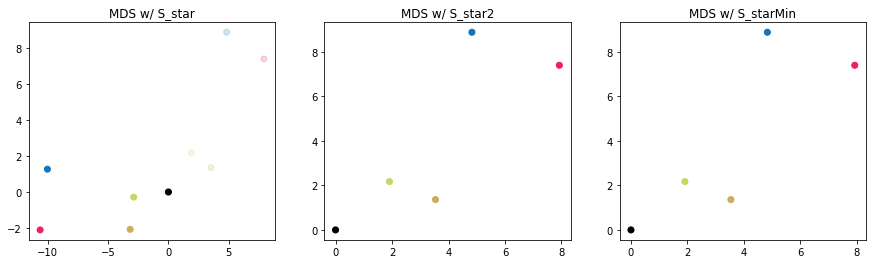

[[ 0.00000000e+00  5.41788836e-14  6.83897383e-14  8.88178420e-15
   1.55431223e-14]
 [ 0.00000000e+00 -6.83897383e-14 -4.08562073e-14 -2.70894418e-14
  -1.42108547e-14]]


In [18]:
theta_r2 = estimate_theta(DM2,DM_prime2,S_star2,[deltaX2,deltaY2],approx=2,verbose=0)
print("theta_r2 : ", theta_r2)


if (theta_r2 != 0):
  F = np.array([[-1,0],[0,1]])
    
  theta_r3 = estimate_theta(DM2,DM_prime,F@S_star,[deltaX1,deltaY1],verbose=0)
  theta = LSE(DM2,DM_prime,F@S_star,[deltaX1,deltaY1])

  print("Wrong estimated angle:",theta_r)
  print("True  estimated angle:", theta_r3)

  S_star2 = rotateMatrix(theta_r3)@F@S_star
  S_starMin = rotateMatrix(theta.x)@F@S_star

print(S[1,:][0])
plot_points(S,S_star  = S_star,
              S_star2 = S_star2,
              S_starMin = S_starMin
            )
print(S-S_star2)

